# Early Prediction of Sepsis from Clinical Data


> Author: Eve Johns <br>
> Modified on: 2020-01-23

## Dataset
Early Prediction of Sepsis from Clinical Data -- the PhysioNet Computing in Cardiology Challenge 2019<br>
https://www.physionet.org/content/challenge-2019/1.0.0/

## Packages

In [1]:
import import_ipynb
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import missingno as msno
from sklearn.model_selection import KFold, StratifiedKFold
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

In [2]:
# import my functions
import my_functions
import my_models
from my_functions import *
from my_models import *

importing Jupyter notebook from my_functions.ipynb
importing Jupyter notebook from my_models.ipynb


## Load Data

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.shape

(436513, 41)

In [5]:
pd.set_option('display.max_columns', None)
df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,ptn,sepsis
0,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,11738,0
1,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,11738,0
2,90.0,95.0,NaN,NaN,NaN,NaN,30.0,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,11738,0
3,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,11738,0
4,110.0,91.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,6,11738,0


## Exploratory Plots

### Class distribution

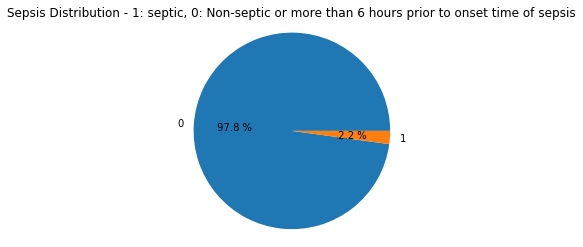

In [6]:
fig, ax = plt.subplots()
ax.set_title('Sepsis Distribution - 1: septic, 0: Non-septic or more than 6 hours prior to onset time of sepsis')
plt.pie(df['sepsis'].value_counts(), labels = list(np.unique(df['sepsis'])), autopct ='% 1.1f %%', shadow = False)
ax.axis('equal')
plt.show()

In [7]:
df['sepsis'].value_counts()

0    427113
1      9400
Name: sepsis, dtype: int64

### Correlation plot

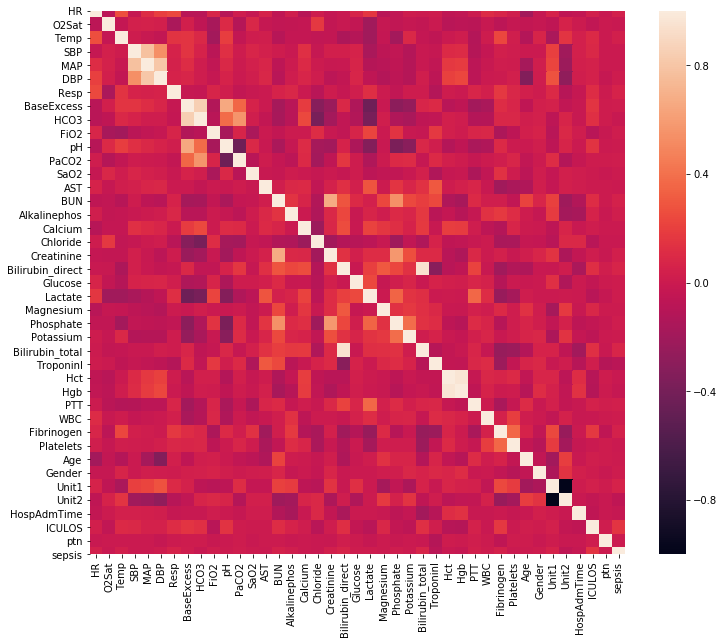

In [8]:
var_Corr = df.corr()
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(var_Corr, xticklabels=var_Corr.columns, yticklabels=var_Corr.columns, annot=False, ax=ax)

### Visualize patient row count distribution

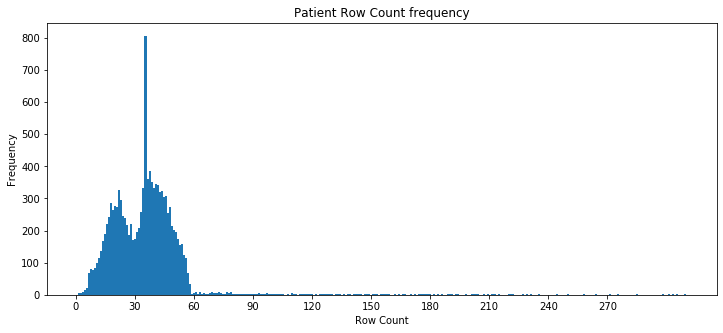

In [9]:
pt_rows = df.groupby(['ptn']).size()
freqPlot(pt_rows, 'Patient Row Count frequency', 'Row Count')

### Visualize missing values

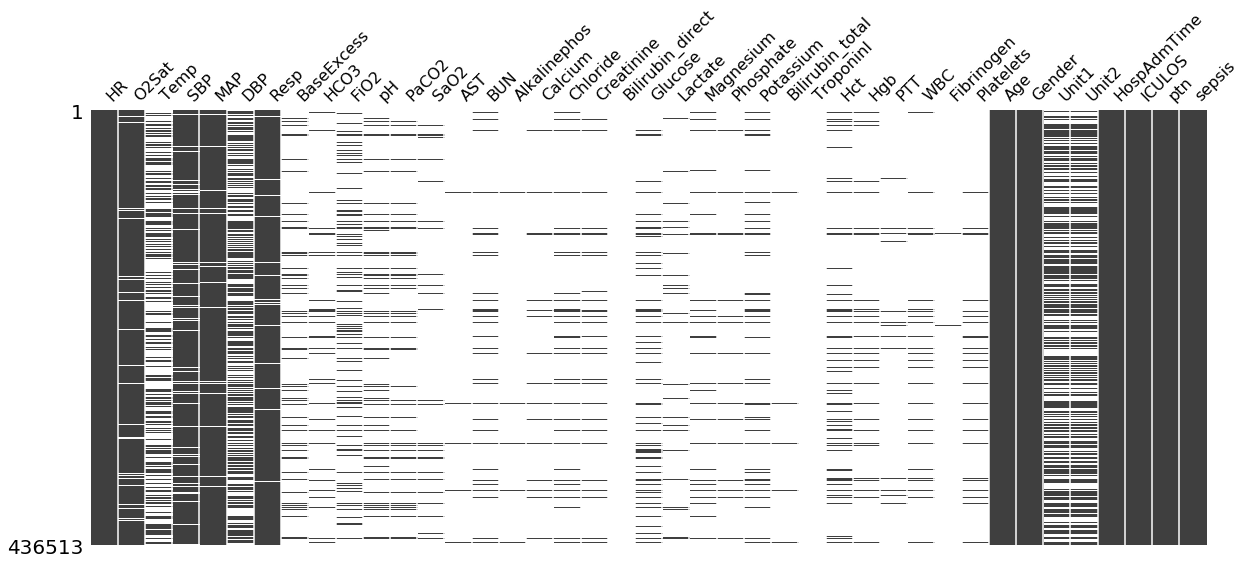

In [10]:
fig, ax = plt.subplots(figsize=(20,8)) 
msno.matrix(df, ax=ax, sparkline=False)

In [11]:
# missing value percentage
na_percent = df.isna().sum()*100/len(df)
df_naPct = na_percent.sort_values(ascending=False)
df_naPct

TroponinI           99.870336
Bilirubin_direct    99.841700
Fibrinogen          99.287306
Bilirubin_total     98.737266
Alkalinephos        98.496723
AST                 98.457778
Lactate             96.615908
PTT                 95.012749
Calcium             94.831998
Phosphate           94.759148
SaO2                94.714934
Platelets           93.267325
Creatinine          93.047401
WBC                 92.175262
Magnesium           91.809179
HCO3                91.551683
BUN                 91.416980
Chloride            91.219964
PaCO2               91.032340
Hgb                 91.026384
BaseExcess          89.276608
Potassium           88.713738
pH                  88.135061
Hct                 87.924758
Glucose             87.366699
FiO2                85.019003
Temp                63.505096
Unit1               48.195128
Unit2               48.195128
DBP                 43.929963
SBP                  8.231141
O2Sat                5.009702
MAP                  2.854440
Resp      

## Data Preprocessing

### Impute Missing Data
1. For each patient, sort by ICULOS then forward-fill missing values 
2. Fill the columns that have all NaNs with "0" for each patient

In [12]:
df_filled = imputeNA(df)

### Feature Engineering
1. Augment feature space with SOFA scores and "organ failure" indication column
2. Feature selection with step-backward feature selection

#### 1. Feature Augmentation 
1) Add SOFA (partial) scores based on Sepsis-3 definition 
<br>
2) Add SOFA score increased points and Organ Failure indication for each patient

In [13]:
df_aug = augFeature(df_filled)

In [14]:
df_aug.shape

(436513, 51)

In [15]:
df_aug.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,ptn,sepsis,SOFA_FiO2,SOFA_MAP,SOFA_BiliTotal,SOFA_Platelets,SOFA_Creatinine,SOFA,SOFA_min,SOFA_max,SOFA_diff,Organ_Failure
0,97.0,95.0,0.0,98.0,75.33,0.0,19.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.14,0,0.0,0.0,-0.03,2,11738,0,4,0,0,4,0,8,2,8,6,1
1,89.0,99.0,0.0,122.0,86.00,0.0,22.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.14,0,0.0,0.0,-0.03,3,11738,0,4,0,0,4,0,8,2,8,6,1
2,90.0,95.0,0.0,122.0,86.00,0.0,30.0,24.0,0.0,0.00,7.36,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.14,0,0.0,0.0,-0.03,4,11738,0,4,0,0,4,0,8,2,8,6,1
3,103.0,88.5,0.0,122.0,91.33,0.0,24.5,24.0,0.0,0.28,7.36,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.14,0,0.0,0.0,-0.03,5,11738,0,2,0,0,4,0,6,2,8,6,1
4,110.0,91.0,0.0,122.0,91.33,0.0,22.0,24.0,0.0,0.28,7.36,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.14,0,0.0,0.0,-0.03,6,11738,0,2,0,0,4,0,6,2,8,6,1


#### 2. Feature Selection

##### 1)  Stratified 10-fold CV split train and test set

In [16]:
X = np.array(df_aug.drop(labels=['sepsis'], axis=1))
y = np.array(df_aug['sepsis'])

In [120]:
kf = StratifiedKFold(n_splits = 10, random_state = 0, shuffle = True) 

In [121]:
for train_index, test_index in kf.split(X, y):
#     print('Train: ', train_index, 'Test: ', test_index)
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [122]:
# convert np arrays back to dataframe prep for the feature selection step
x_train_df = pd.DataFrame(x_train, columns = list(df_aug.drop(labels=['sepsis'], axis=1).columns))
y_train_df = pd.DataFrame(y_train, columns = ['sepsis'])
x_test_df = pd.DataFrame(x_test, columns = list(df_aug.drop(labels=['sepsis'], axis=1).columns))
y_test_df = pd.DataFrame(y_test, columns = ['sepsis'])

##### 2) Step Backward Feature Selection

##### 50 features down to 44 features

In [144]:
var_drop_list = backElm(x_train_df, y_train_df)

kept features:  ['HR', 'O2Sat', 'Temp', 'SBP', 'DBP', 'Resp', 'BaseExcess', 'HCO3', 'pH', 'PaCO2', 'SaO2', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SOFA_FiO2', 'SOFA_MAP', 'SOFA_BiliTotal', 'SOFA_Platelets', 'SOFA', 'SOFA_min', 'SOFA_max', 'SOFA_diff', 'Organ_Failure']
removed features:  ['ptn', 'Bilirubin_direct', 'Glucose', 'MAP', 'FiO2', 'SOFA_Creatinine', 'AST', 'BUN']


In [124]:
var_drop_list

['ptn',
 'Bilirubin_direct',
 'Glucose',
 'MAP',
 'FiO2',
 'SOFA_Creatinine',
 'AST',
 'BUN']

In [146]:
x_train = x_train_df.drop(var_drop_list, axis=1)
x_train.shape

(392862, 39)

In [147]:
x_test = x_test_df.drop(var_drop_list, axis=1)
x_test.shape

(43651, 39)

## Methods

1. Logistic Regression
2. Random Forest
3. XGBoost

In [148]:
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (392862, 39)
Training Labels Shape: (392862,)
Testing Features Shape: (43651, 39)
Testing Labels Shape: (43651,)


In [128]:
test = pd.read_csv('test.csv')
test.shape

(292509, 40)

### 1. Logistic Regression

#### Train Model

In [ ]:
model_lr = LogisticRegression(random_state=0, n_jobs=-1, solver='lbfgs', class_weight='balanced')
model_lr.fit(x_train, y_train)

#### Prediction

In [ ]:
y_pred_lr = model_lr.predict(x_test)
y_prob_lr = model_lr.predict_proba(x_test)[:,1]

In [ ]:
print('Prediction Value Counts:')
print(pd.Series(y_pred_lr).value_counts())

In [ ]:
# acc
accuracy_score(y_test, y_pred_lr)

In [ ]:
# roc auc
roc_value = roc_auc_score(y_test, y_prob_lr)
roc_value

In [ ]:
plot_ROC(y_test, y_prob_lr, title='Logistic Regression')

In [ ]:
# saving the model
with open('pickle/model_lr.pickle', 'wb') as lr_file:
    pickle.dump(model_lr, lr_file)

In [ ]:
print(classification_report(y_test, y_pred_lr, digits=3))

### 2. Random Forest

Estimate optimal number of trees

In [ ]:
n_estimators = [1, 10, 50, 80, 100, 120, 150] 
n_trees = RF_ntrees(n_estimators, x_train, y_train, x_test, y_test)

Estimate max_depth

#### Train model

In [104]:
model_rf = RandomForestClassifier(n_estimators=n_trees, max_depth = max_depth
                                  , bootstrap = True, random_state = 0
                                  , class_weight = 'balanced', n_jobs = -1
                                  )
model_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### Feature importance plot 

In [194]:
importances = model_rf.feature_importances_

In [195]:
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

In [196]:
indices_df = pd.DataFrame(indices, columns=['col_index'])
col_mapping = pd.DataFrame(x_train.columns.values.tolist(),columns=['col_name'])
col_mapping.index += 1 
col_mapping.reset_index(level=0, inplace=True)
f_ranking = indices_df.join(col_mapping.set_index('index'), on='col_index')

In [197]:
# Print the feature ranking
print('Feature ranking:')
for f, name in  zip(range(x_train.shape[1]), f_ranking['col_name'].values):
    print('%d. %s (%f)' %(f + 1, name, importances[indices[f]]))

Feature ranking:
1. HospAdmTime (0.130077)
2. O2Sat (0.048007)
3. Platelets (0.047796)
4. Unit2 (0.047205)
5. WBC (0.038038)
6. Bilirubin_direct (0.035100)
7. SOFA_Platelets (0.033818)
8. Hgb (0.033541)
9. TroponinI (0.032963)
10. Magnesium (0.031091)
11. nan (0.030618)
12. Calcium (0.029657)
13. Alkalinephos (0.028349)
14. Temp (0.028248)
15. SOFA_max (0.027964)
16. DBP (0.027689)
17. HCO3 (0.027144)
18. SaO2 (0.026168)
19. BaseExcess (0.025536)
20. Unit1 (0.024927)
21. Phosphate (0.023071)
22. FiO2 (0.021633)
23. Lactate (0.021505)
24. pH (0.021432)
25. Potassium (0.018630)
26. SBP (0.017999)
27. Resp (0.017754)
28. SOFA_min (0.017506)
29. MAP (0.017357)
30. ICULOS (0.016763)
31. HR (0.012909)
32. PaCO2 (0.011516)
33. SOFA_BiliTotal (0.007438)
34. Gender (0.006115)
35. Age (0.006047)
36. SOFA_MAP (0.002641)
37. Creatinine (0.002562)
38. SOFA_FiO2 (0.001783)
39. Bilirubin_total (0.001400)


In [198]:
importances[indices][0:10]

array([0.13007671, 0.04800697, 0.04779569, 0.04720516, 0.03803826,
       0.03510008, 0.03381824, 0.03354121, 0.03296286, 0.03109128])

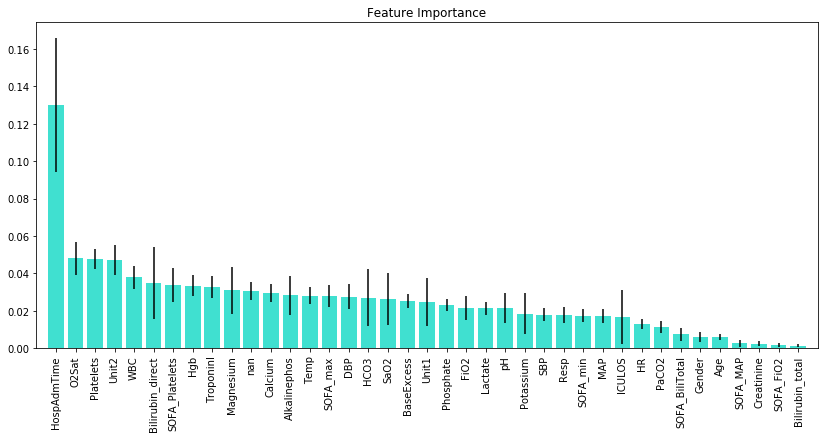

In [199]:
# Plot the feature importances of the forest
fig, ax = plt.subplots(figsize=(14,6)) 
plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]), importances[indices],
       color='#40E0D0', yerr=std[indices], align='center')
plt.xticks(range(x_train.shape[1]), f_ranking['col_name'].values, rotation='90')
plt.xlim([-1, x_train.shape[1]])
plt.show()

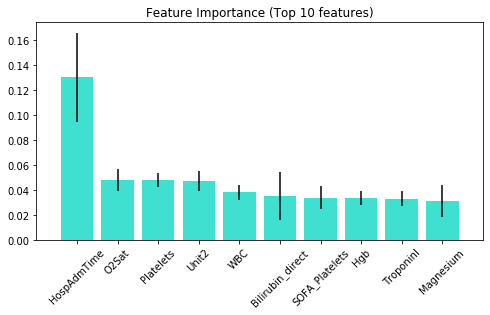

In [200]:
# Plot the TOP 10 feature importances of the forest
fig, ax = plt.subplots(figsize=(8,4)) 
plt.title('Feature Importance (Top 10 features)')
plt.bar(range(10), importances[indices][0:10],
       color='#40E0D0', yerr=std[indices][0:10], align='center')
plt.xticks(range(10), f_ranking['col_name'].values[0:10], rotation='45')
plt.xlim([-1, 10])
plt.show()

#### Prediction

In [201]:
y_pred_rf = model_rf.predict(x_test)
y_prob_rf = model_rf.predict_proba(x_test)[:, 1]

In [202]:
print('Prediction Value Counts:')
print(pd.Series(y_pred_rf).value_counts())

Prediction Value Counts:
0    42333
1     1318
dtype: int64


In [203]:
print(classification_report(y_test, y_pred_rf, digits=3))

              precision    recall  f1-score   support

           0      0.997     0.988     0.992     42711
           1      0.608     0.852     0.709       940

    accuracy                          0.985     43651
   macro avg      0.802     0.920     0.851     43651
weighted avg      0.988     0.985     0.986     43651



In [204]:
# confusion matrix
matrix = confusion_matrix(y_test, y_pred_rf)
print(matrix)

[[42194   517]
 [  139   801]]


In [205]:
accuracy_score(y_test, y_pred_rf)

0.9849717074064741

In [206]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, y_prob_rf)
roc_value

0.9917698465241651

Random Forest: ROC AUC=0.992


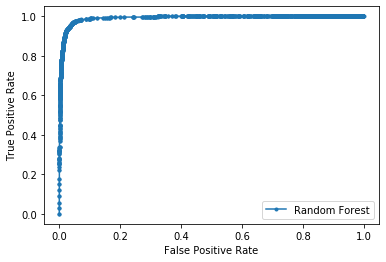

In [207]:
# ROC
roc_value = roc_auc_score(y_test, y_prob_rf)
print('Random Forest: ROC AUC=%.3f' % (roc_value))
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# for saving the model
with open('pickle/model_rf.pickle', 'wb') as rf_file:
    pickle.dump(model_rf, rf_file)

#### Generate submission

Pre-process test file

In [51]:
test_filled = imputeNA(test)

In [52]:
test_aug = augFeature(test_filled)

In [53]:
test_aug.shape

(292509, 50)

In [54]:
test_X = test_aug.drop(var_drop_list, axis=1)
test_X.shape

(292509, 44)

Predict with Test file and generate submission

In [55]:
# Predict with Test file and generate submission
pred = model_rf.predict(test_X)
print('Prediction Value Counts:')
print(pd.Series(pred).value_counts())

Prediction Value Counts:
0    285056
1      7453
dtype: int64


In [56]:
pred_prob = model_rf.predict_proba(test_X)[:,1]

In [57]:
df_preds = pd.DataFrame(test[['ptn']]).copy()
df_preds['sepsis'] = pd.DataFrame(pred_prob).astype(np.float32)

In [58]:
# Find the Max sepsis prediction for each Patient
df_submit = df_preds.groupby('ptn')['ptn', 'sepsis'].max().copy()
df_submit.columns = ['ptn', 'sepsis']
df_submit

,ptn,sepsis
ptn,,
1,1,0.016867
2,2,0.129532
3,3,0.033894
4,4,0.094920
5,5,0.175965
...,...,...
8130,8130,0.126413
8131,8131,0.157301
8132,8132,0.200265


In [59]:
df_submit.to_csv('Submission11_RandomForest_44features_SKFCV.csv', index=False)

### 3. XGBoost

In [ ]:
model_xgb = xgb.XGBClassifier(n_estimators = 1000, booster='gbtree', objective='binary:logistic', eta=0.2, colsample_bytree=0.7) 

In [ ]:
model_xgb.fit(x_train, y_train)

In [ ]:
y_pred_xgb = model_xgb.predict(x_test)
y_prob_xgb = model_xgb.predict_proba(x_test)[:, 1]

In [ ]:
accuracy_score(y_test, y_pred_xgb)

In [ ]:
print(classification_report(y_test, y_pred_xgb, digits=3))

In [ ]:
roc_value = roc_auc_score(y_test, y_prob_xgb)
roc_value

In [ ]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, y_prob_xgb)
print('XGBoost: ROC AUC=%.3f' % (roc_value))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_prob_xgb)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# for saving the model
with open('pickle/model_xgb.pickle', 'wb') as xgb_file:
    pickle.dump(model_xgb, xgb_file)

## Results

In [ ]:
classifiers = [model_lr, model_rf, model_xgb]
y_probs = [y_prob_lr, y_prob_rf, y_prob_xgb]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
    
for c, y_prob in zip(classifiers, y_probs):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    result_table = result_table.append({'classifiers':c.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

In [ ]:
fig = plt.figure(figsize=(12, 8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label='{}, AUC={:.3f}'.format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel('Flase Positive Rate', fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel('True Positive Rate', fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [ ]:
fig.savefig('roc_comparison.png')

Metrics Comparison:

|Method|Sensitivity|Specificity|F Score|Accuracy|AUC
|:---:|:---:|:---:|:---:|:---:|:---:|
|Logistic Regression|0.971|0.757|0.843|0.757|0.802|
|Random Forest|0.995|0.995|0.994|0.995|0.999|
|XGBoost|0.981|0.982|0.976|0.982|0.958|